In [1]:
from google.colab import files
uploaded = files.upload()

Saving openaq 2.csv to openaq 2.csv


In [2]:
!pip install reverse_geocoder
import reverse_geocoder as rg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268067 sha256=f67cdd06710d25726d25ad81a30dd81cb95bed83605142db7c2edfe6ec4896fc
  Stored in directory: /root/.cache/pip/wheels/11/e1/67/6e47f0ad41ea1843d37e1fbe79c6074744a1f4aace641cf800
Successfully built reverse_geocoder


In [3]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv("openaq 2.csv", sep=';')
print("\nRAW HEAD:")
print(df.head())


RAW HEAD:
  Country Code                 City             Location  \
0           HU  Budapest Budatétény  Budapest Budatétény   
1           HU      Budapest Honvéd      Budapest Honvéd   
2           HU             Budapest              HU0045A   
3           HU        Kazincbarcika        Kazincbarcika   
4           HU       Székesfehérvár       Székesfehérvár   

                     Coordinates Pollutant  Source Name   Unit       Value  \
0              47.40605, 19.0099     PM2.5  hungary-nms  µg/m³    7.000000   
1           47.522693, 19.069867        CO  hungary-nms  µg/m³  289.000000   
2  47.4919433594653, 19.08778191       SO2  EEA Hungary  µg/m³    5.496181   
3   48.247032999999995, 20.61445      PM10  hungary-nms  µg/m³    6.000000   
4           47.195944, 18.400246        CO  hungary-nms  µg/m³  237.000000   

                Last Updated Country Label  
0  2023-08-03T22:00:00+10:00       Hungary  
1  2023-08-10T06:00:00+10:00       Hungary  
2  2023-08-10T06:00:00+1

In [4]:
if 'Latitude' not in df.columns or 'Longitude' not in df.columns:
    df[['Latitude_str', 'Longitude_str']] = df['Coordinates'].str.split(',', expand=True)
    df['Latitude'] = pd.to_numeric(df['Latitude_str'].str.strip(), errors='coerce')
    df['Longitude'] = pd.to_numeric(df['Longitude_str'].str.strip(), errors='coerce')
    df.drop(columns=['Latitude_str', 'Longitude_str'], inplace=True)

# Keep only necessary columns
df = df[['Country Label', 'Pollutant', 'Value', 'Latitude', 'Longitude']]
print("\nAFTER BASIC CLEAN:")
print(df.head())



AFTER BASIC CLEAN:
  Country Label Pollutant       Value   Latitude  Longitude
0       Hungary     PM2.5    7.000000  47.406050  19.009900
1       Hungary        CO  289.000000  47.522693  19.069867
2       Hungary       SO2    5.496181  47.491943  19.087782
3       Hungary      PM10    6.000000  48.247033  20.614450
4       Hungary        CO  237.000000  47.195944  18.400246


In [5]:
def fill_missing_coordinates(df):
    # Country-level median fill
    df['Latitude'] = df.groupby('Country Label')['Latitude'].transform(
        lambda x: x.fillna(x.median())
    )
    df['Longitude'] = df.groupby('Country Label')['Longitude'].transform(
        lambda x: x.fillna(x.median())
    )

    # Continent-level median fill
    if 'Continent' in df.columns:
        df['Latitude'] = df.groupby('Continent')['Latitude'].transform(
            lambda x: x.fillna(x.median())
        )
        df['Longitude'] = df.groupby('Continent')['Longitude'].transform(
            lambda x: x.fillna(x.median())
        )

    # Global median fill
    df['Latitude'].fillna(df['Latitude'].median(), inplace=True)
    df['Longitude'].fillna(df['Longitude'].median(), inplace=True)

    return df



df = fill_missing_coordinates(df)

In [6]:
# Mapping table (ISO → continent)
country_to_continent = {
    'AF':'Asia','AX':'Europe','AL':'Europe','DZ':'Africa','AS':'Oceania','AD':'Europe','AO':'Africa',
    'AI':'North America','AQ':'Antarctica','AG':'North America','AR':'South America','AM':'Asia',
    'AW':'North America','AU':'Oceania','AT':'Europe','AZ':'Asia','BS':'North America','BH':'Asia',
    'BD':'Asia','BB':'North America','BY':'Europe','BE':'Europe','BZ':'North America','BJ':'Africa',
    'BM':'North America','BT':'Asia','BO':'South America','BQ':'North America','BA':'Europe',
    'BW':'Africa','BV':'Antarctica','BR':'South America','IO':'Asia','BN':'Asia','BG':'Europe',
    'BF':'Africa','BI':'Africa','KH':'Asia','CM':'Africa','CA':'North America','CV':'Africa',
    'KY':'North America','CF':'Africa','TD':'Africa','CL':'South America','CN':'Asia','CX':'Asia',
    'CC':'Asia','CO':'South America','KM':'Africa','CG':'Africa','CD':'Africa','CK':'Oceania',
    'CR':'North America','CI':'Africa','HR':'Europe','CU':'North America','CW':'North America',
    'CY':'Asia','CZ':'Europe','DK':'Europe','DJ':'Africa','DM':'North America','DO':'North America',
    'EC':'South America','EG':'Africa','SV':'North America','GQ':'Africa','ER':'Africa','EE':'Europe',
    'SZ':'Africa','ET':'Africa','FK':'South America','FO':'Europe','FJ':'Oceania','FI':'Europe',
    'FR':'Europe','GF':'South America','PF':'Oceania','TF':'Antarctica','GA':'Africa','GM':'Africa',
    'GE':'Asia','DE':'Europe','GH':'Africa','GI':'Europe','GR':'Europe','GL':'North America',
    'GD':'North America','GP':'North America','GU':'Oceania','GT':'North America','GG':'Europe',
    'GN':'Africa','GW':'Africa','GY':'South America','HT':'North America','HM':'Antarctica',
    'VA':'Europe','HN':'North America','HK':'Asia','HU':'Europe','IS':'Europe','IN':'Asia',
    'ID':'Asia','IR':'Asia','IQ':'Asia','IE':'Europe','IM':'Europe','IL':'Asia','IT':'Europe',
    'JM':'North America','JP':'Asia','JE':'Europe','JO':'Asia','KZ':'Asia','KE':'Africa',
    'KI':'Oceania','KP':'Asia','KR':'Asia','KW':'Asia','KG':'Asia','LA':'Asia','LV':'Europe',
    'LB':'Asia','LS':'Africa','LR':'Africa','LY':'Africa','LI':'Europe','LT':'Europe','LU':'Europe',
    'MO':'Asia','MK':'Europe','MG':'Africa','MW':'Africa','MY':'Asia','MV':'Asia','ML':'Africa',
    'MT':'Europe','MH':'Oceania','MQ':'North America','MR':'Africa','MU':'Africa','YT':'Africa',
    'MX':'North America','FM':'Oceania','MD':'Europe','MC':'Europe','MN':'Asia','ME':'Europe',
    'MS':'North America','MA':'Africa','MZ':'Africa','MM':'Asia','NA':'Africa','NR':'Oceania',
    'NP':'Asia','NL':'Europe','NC':'Oceania','NZ':'Oceania','NI':'North America','NE':'Africa',
    'NG':'Africa','NU':'Oceania','NF':'Oceania','MP':'Oceania','NO':'Europe','OM':'Asia',
    'PK':'Asia','PW':'Oceania','PS':'Asia','PA':'North America','PG':'Oceania','PY':'South America',
    'PE':'South America','PH':'Asia','PN':'Oceania','PL':'Europe','PT':'Europe','PR':'North America',
    'QA':'Asia','RE':'Africa','RO':'Europe','RU':'Europe','RW':'Africa','BL':'North America',
    'SH':'Africa','KN':'North America','LC':'North America','MF':'North America','PM':'North America',
    'VC':'North America','WS':'Oceania','SM':'Europe','ST':'Africa','SA':'Asia','SN':'Africa',
    'RS':'Europe','SC':'Africa','SL':'Africa','SG':'Asia','SX':'North America','SK':'Europe',
    'SI':'Europe','SB':'Oceania','SO':'Africa','ZA':'Africa','GS':'Antarctica','SS':'Africa',
    'ES':'Europe','LK':'Asia','SD':'Africa','SR':'South America','SJ':'Europe','SE':'Europe',
    'CH':'Europe','SY':'Asia','TW':'Asia','TJ':'Asia','TZ':'Africa','TH':'Asia','TL':'Asia',
    'TG':'Africa','TK':'Oceania','TO':'Oceania','TT':'North America','TN':'Africa','TR':'Asia',
    'TM':'Asia','TC':'North America','TV':'Oceania','UG':'Africa','UA':'Europe','AE':'Asia',
    'GB':'Europe','US':'North America','UM':'Oceania','UY':'South America','UZ':'Asia',
    'VU':'Oceania','VE':'South America','VN':'Asia','VG':'North America','VI':'North America',
    'WF':'Oceania','EH':'Africa','YE':'Asia','ZM':'Africa','ZW':'Africa'
}


In [7]:
# 1. Get unique coordinate pairs
unique_coords = df[['Latitude', 'Longitude']].drop_duplicates()

# 2. Reverse geocode ONLY the unique coordinates
def fast_get_continent(df_unique):
    coords_list = list(zip(df_unique['Latitude'], df_unique['Longitude']))
    results = rg.search(coords_list)             # fast batch lookup
    continents = []

    for res in results:
        cc = res['cc']
        continents.append(country_to_continent.get(cc, "Unknown"))

    df_unique['Continent'] = continents
    return df_unique

unique_coords = fast_get_continent(unique_coords)

# 3. Merge back to original df (VERY FAST)
df = df.merge(unique_coords, on=['Latitude', 'Longitude'], how='left')

# 4. Filter valid continents
valid_continents = ['Africa','Asia','Europe','North America','South America','Oceania','Antarctica']
df = df[df['Continent'].isin(valid_continents)]



Loading formatted geocoded file...


In [8]:
df['Value'] = df['Value'].clip(lower=0)

In [9]:
print(df.isnull().sum())

Country Label    115
Pollutant          0
Value              0
Latitude           0
Longitude          0
Continent          0
dtype: int64


In [10]:
pollutants_distinct = df['Pollutant'].unique()
print(pollutants_distinct)



['PM2.5' 'CO' 'SO2' 'PM10' 'NO2' 'O3' 'NO' 'NOX' 'BC' 'PM1']


In [11]:
df.head()

,Country Label,Pollutant,Value,Latitude,Longitude,Continent
0,Hungary,PM2.5,7.000000,47.406050,19.009900,Europe
1,Hungary,CO,289.000000,47.522693,19.069867,Europe
2,Hungary,SO2,5.496181,47.491943,19.087782,Europe
3,Hungary,PM10,6.000000,48.247033,20.614450,Europe
4,Hungary,CO,237.000000,47.195944,18.400246,Europe


In [12]:
df.describe(include='all')

,Country Label,Pollutant,Value,Latitude,Longitude,Continent
count,43327,43442,4.344200e+04,43442.000000,43442.000000,43442
unique,112,10,NaN,NaN,NaN,6
top,China,PM2.5,NaN,NaN,NaN,Asia
freq,11112,7845,NaN,NaN,NaN,18231
mean,NaN,NaN,7.793219e+02,32.671928,26.691179,NaN
std,NaN,NaN,3.271021e+04,20.115546,77.896498,NaN
min,NaN,NaN,0.000000e+00,-53.158295,-161.767000,NaN
25%,NaN,NaN,1.600000e+00,27.648600,-2.750000,NaN
50%,NaN,NaN,1.040000e+01,37.754100,20.345513,NaN
75%,NaN,NaN,3.684375e+01,44.838586,105.669800,NaN


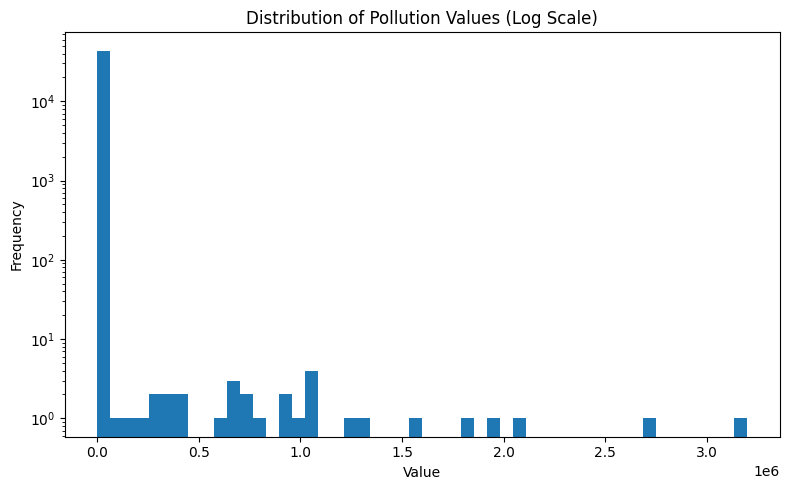

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(df['Value'], bins=50)
plt.yscale('log')
plt.title("Distribution of Pollution Values (Log Scale)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

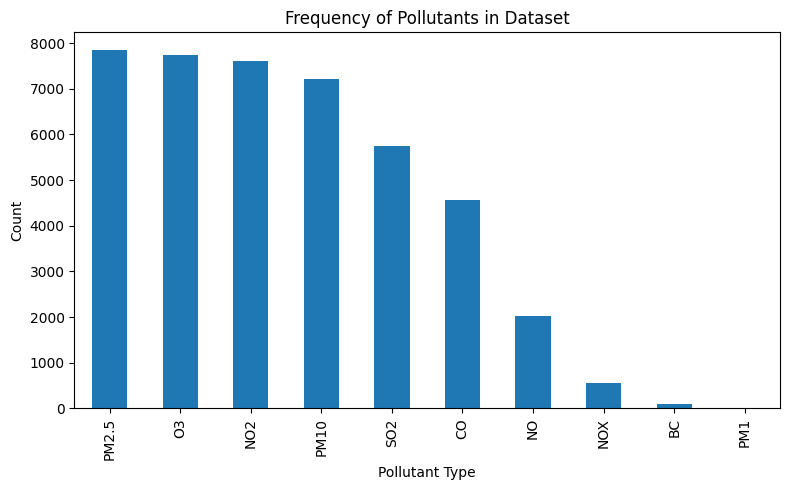

In [14]:
# Visualization 3: Pollutant frequency count
pollutant_counts = df['Pollutant'].value_counts()

plt.figure(figsize=(8,5))
pollutant_counts.plot(kind='bar')
plt.title("Frequency of Pollutants in Dataset")
plt.xlabel("Pollutant Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [15]:
continent_group = df.groupby(["Continent", "Pollutant"])["Value"].mean().unstack().fillna(0)
print(continent_group)

Pollutant            BC            CO        NO        NO2        NOX  \
Continent                                                               
Africa         0.000000      1.089267  0.036426   0.011045   0.011839   
Asia           0.000000  11083.100112  0.732459  20.522130  10.755386   
Europe         0.641393    405.284422  4.103987  14.846430  14.752475   
North America  0.446897      6.391929  0.007539   0.066423   0.015617   
Oceania        0.000000      9.807745  0.000000   0.596059   0.000000   
South America  0.000000    404.390368  2.890000  21.735176  32.387500   

Pollutant             O3       PM1       PM10      PM2.5        SO2  
Continent                                                            
Africa          0.097786  0.000000  39.248615  21.922948   0.027362  
Asia           90.239636  0.000000  59.367268  31.626893   9.361190  
Europe         56.248065  2.179167  17.303413   8.664607   6.049854  
North America   0.070790  0.000000  28.899948  11.350250   0.0122

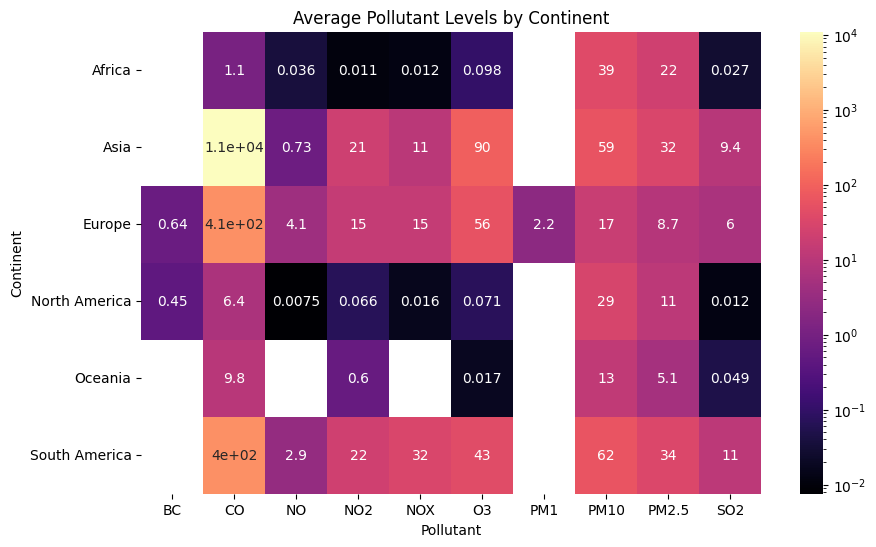

In [16]:
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(continent_group, annot=True, cmap="magma", norm=LogNorm())
plt.title("Average Pollutant Levels by Continent")
plt.show()

**Interpretation of the Heatmap:**

🌍 Asia

Extremely high BC (black carbon) and CO → tied to massive industrialization + traffic.

High PM2.5/PM10 shows strong particulate pollution.
➡ Asia is the most polluted continent overall.

🇪🇺 Europe

Very elevated SO₂ → comes from coal-based power generation.

Moderate PM2.5/PM10.

🌍 Africa

Higher CO → open burning, charcoal production, agricultural fires.

🌎 North America

Lowest pollutant levels → strong regulations & cleaner technologies.

🏝 Oceania

Cleanest overall values.

🌎 South America

Moderate levels

PM10 slightly elevated (dust, urban emissions)

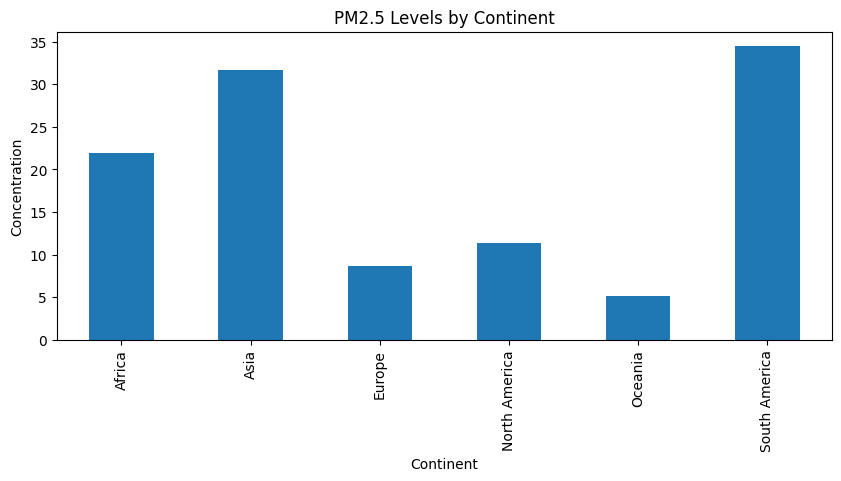

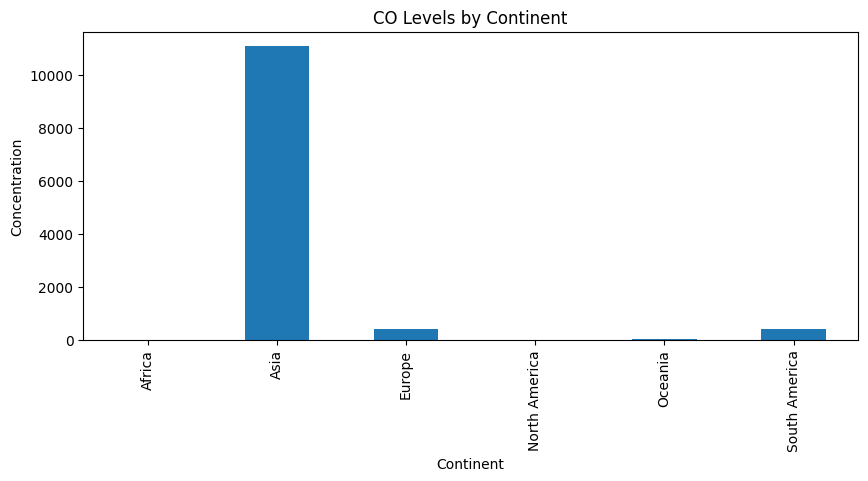

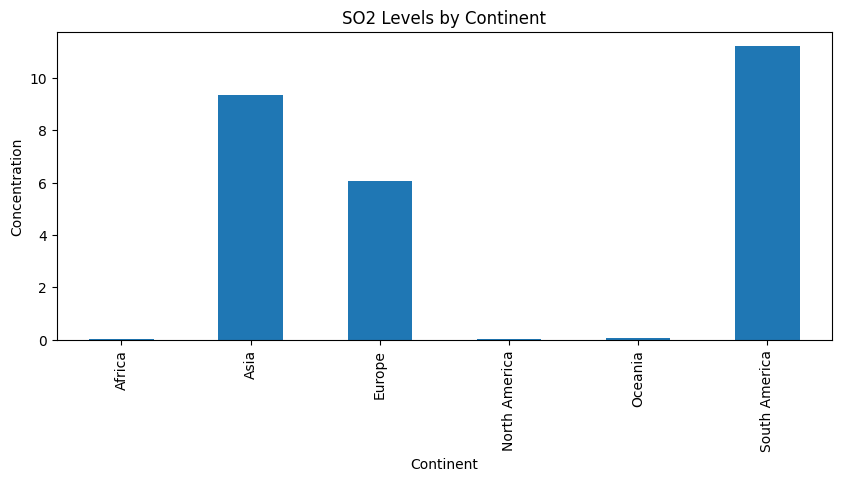

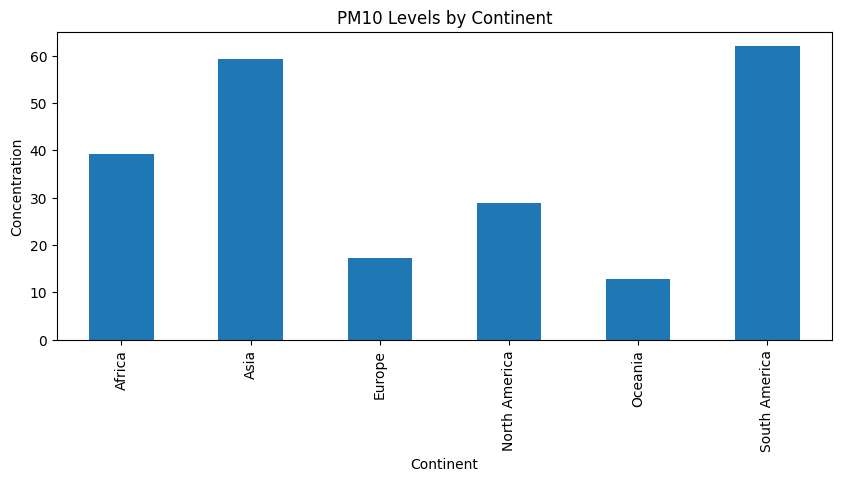

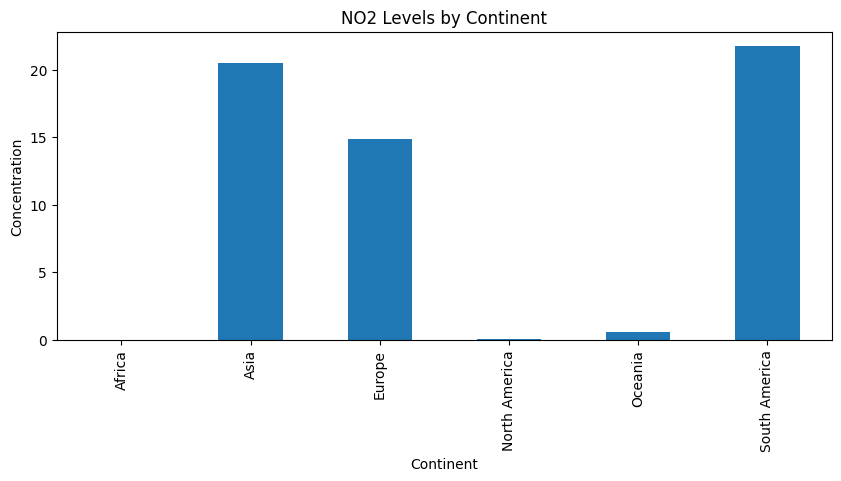

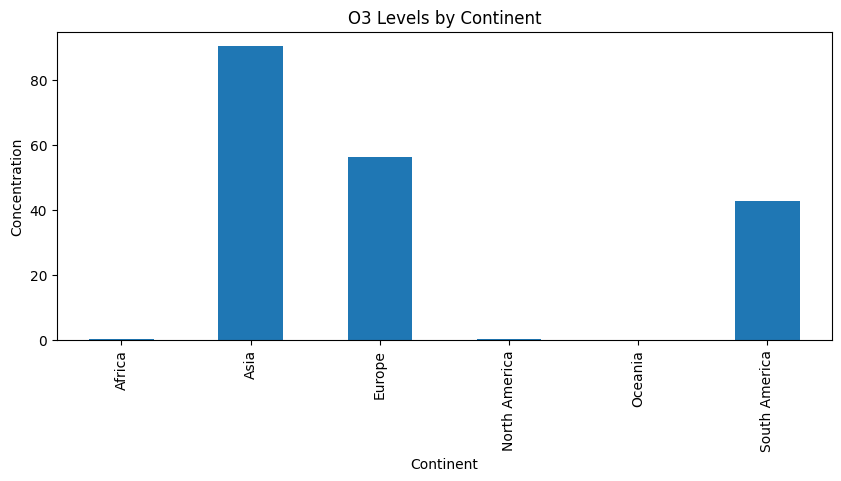

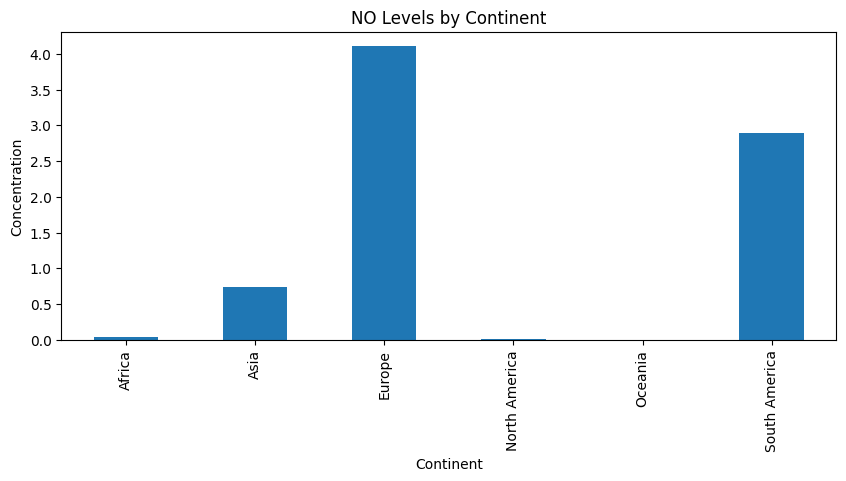

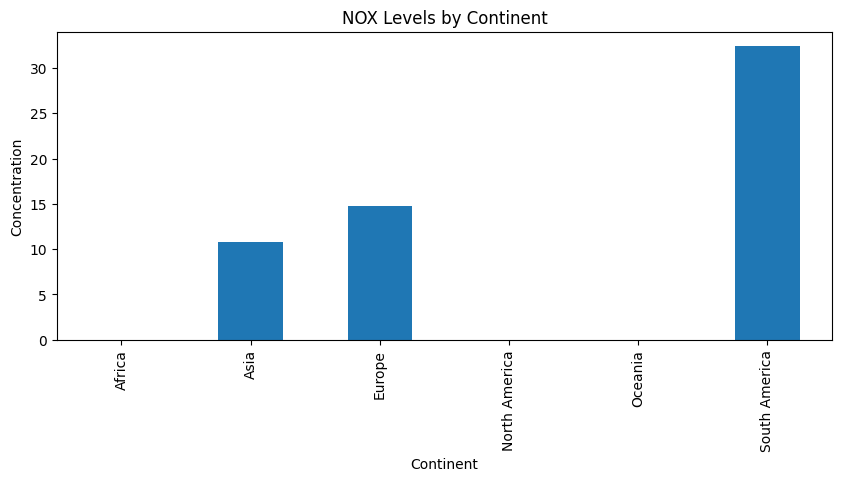

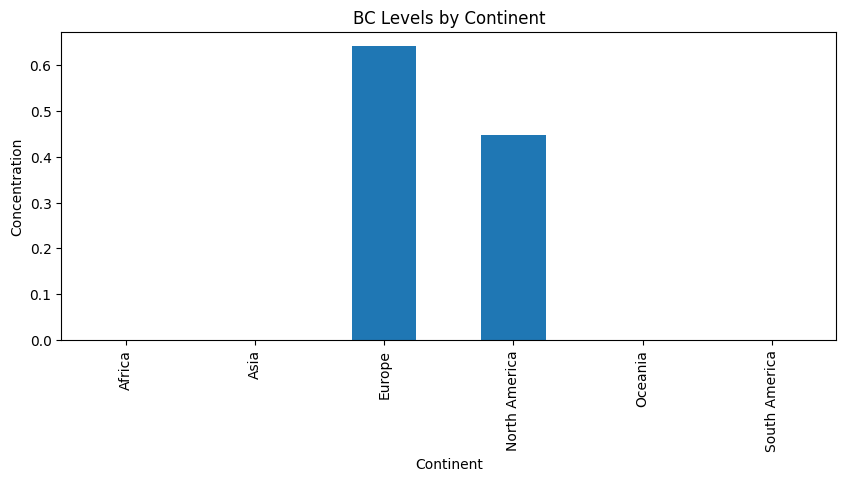

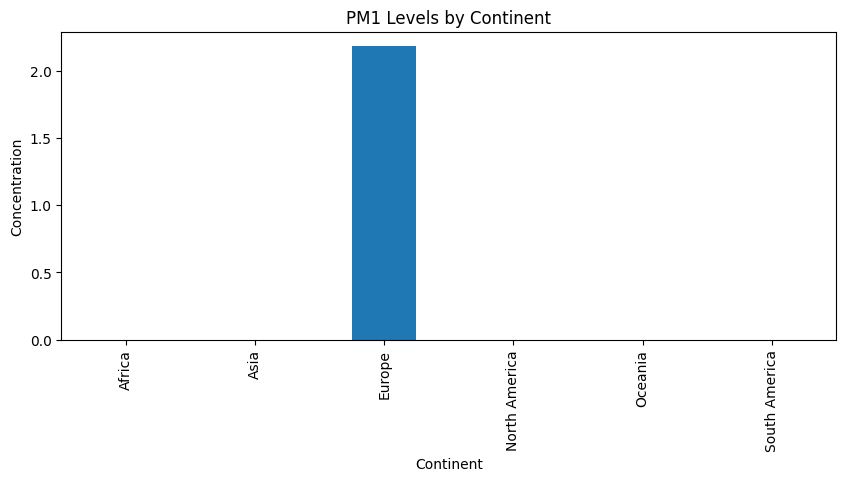

In [17]:
for col in pollutants_distinct:
    plt.figure(figsize=(10,4))
    continent_group[col].plot(kind='bar')
    plt.title(f"{col} Levels by Continent")
    plt.ylabel("Concentration")
    plt.show()


In [18]:
corr_matrix = continent_group.corr()
print(corr_matrix)

Pollutant        BC        CO        NO       NO2       NOX        O3  \
Pollutant                                                               
BC         1.000000 -0.295712  0.481613 -0.061056 -0.056198  0.032906   
CO        -0.295712  1.000000 -0.113304  0.541365  0.081416  0.787821   
NO         0.481613 -0.113304  1.000000  0.683929  0.766143  0.522336   
NO2       -0.061056  0.541365  0.683929  1.000000  0.864584  0.895955   
NOX       -0.056198  0.081416  0.766143  0.864584  1.000000  0.557081   
O3         0.032906  0.787821  0.522336  0.895955  0.557081  1.000000   
PM1        0.783454 -0.173466  0.777325  0.241931  0.194681  0.320167   
PM10      -0.529187  0.548625  0.058026  0.652345  0.584914  0.520226   
PM2.5     -0.556021  0.520211  0.115753  0.675359  0.620344  0.531216   
SO2       -0.130124  0.505785  0.650937  0.992829  0.898675  0.847107   

Pollutant       PM1      PM10     PM2.5       SO2  
Pollutant                                          
BC         0.783454

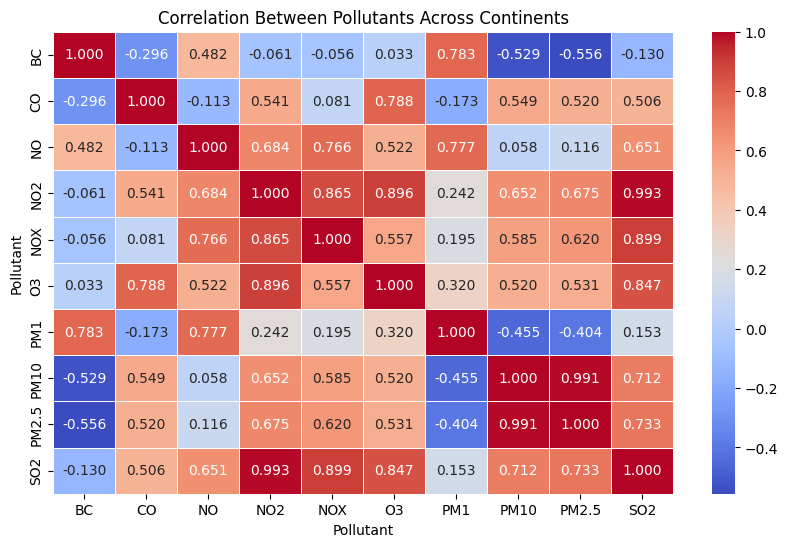

In [19]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Pollutants Across Continents")
plt.show()

**Very high positive correlations (0.8–0.99)**
---
SO₂ ↔ NO₂ (0.993)

Strong indicator of industrial + vehicle combustion occurring in the same regions.

PM2.5 ↔ PM10 (0.991)

Expected because both are particulate matter:

PM10 = coarse dust

PM2.5 = fine particles

These pollutants often rise and fall together.

NO ↔ NO₂ (0.866)

Both are nitrogen oxides and share similar emission sources:

Traffic

Industrial combustion

**Medium positive correlations (0.5–0.8)**
---
CO ↔ O3 (0.788)

CO emissions often come from incomplete combustion

Ozone formation is linked to NOx + hydrocarbons → related chemistry

BC ↔ PM1 / PM10 / PM2.5 (0.78, -0.52, -0.55)

BC correlates strongly with PM1 (fine particles), but negatively with PM10.
This is true because:

PM10 includes dust + soil particles → unrelated to BC

PM1 includes combustion particles → directly related to BC

**Negative correlations**
---
BC ↔ PM10 (-0.529)

Means:

Areas with high black carbon (industrial, traffic-heavy)

Do not necessarily have high coarse dust (PM10)

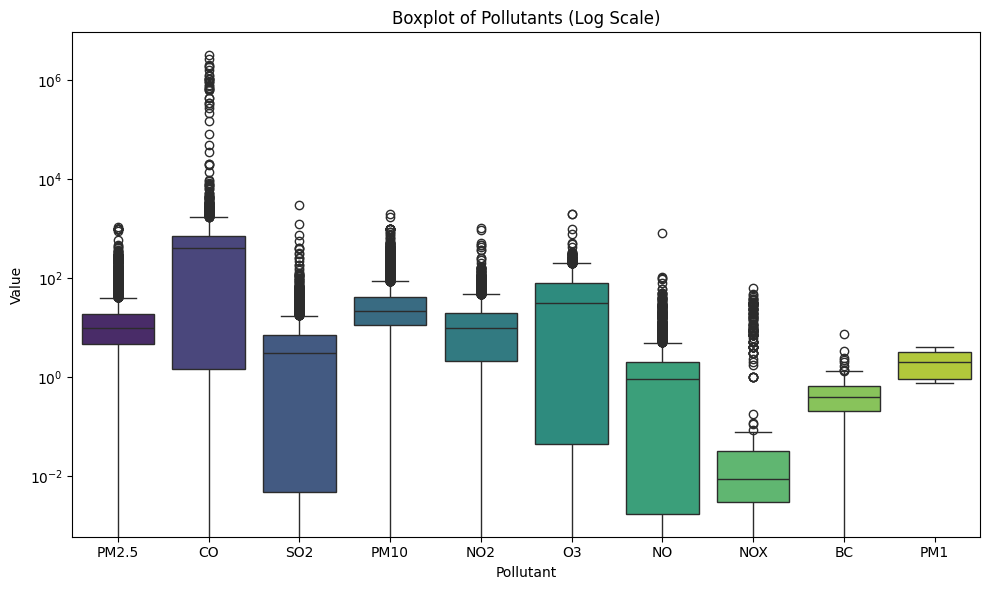

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Pollutant", y="Value", palette="viridis")
plt.yscale("log")
plt.title("Boxplot of Pollutants (Log Scale)")
plt.tight_layout()
plt.show()

In [21]:
df.to_csv('openaq_cleaned.csv', index=False)
files.download('openaq_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

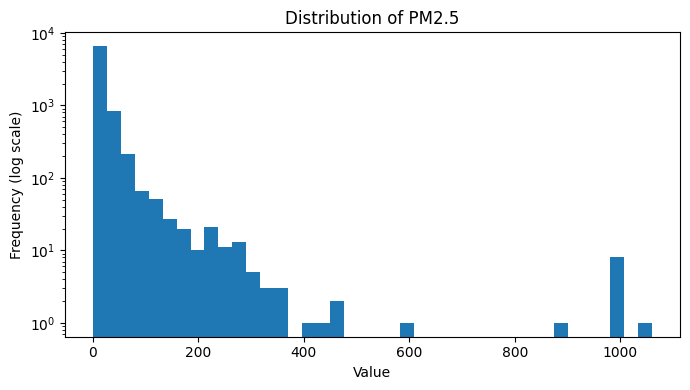

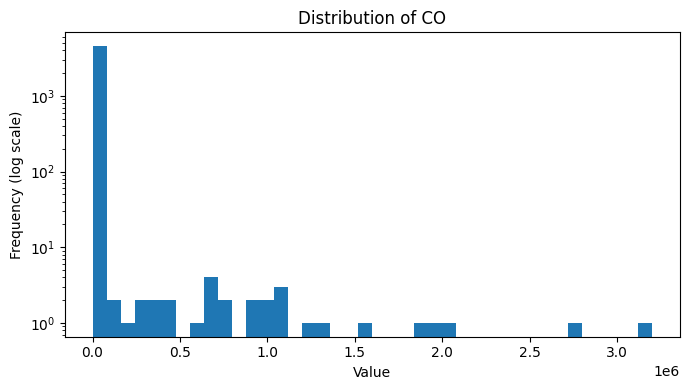

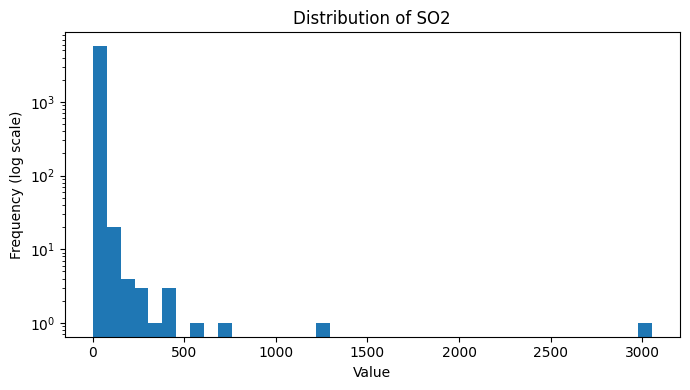

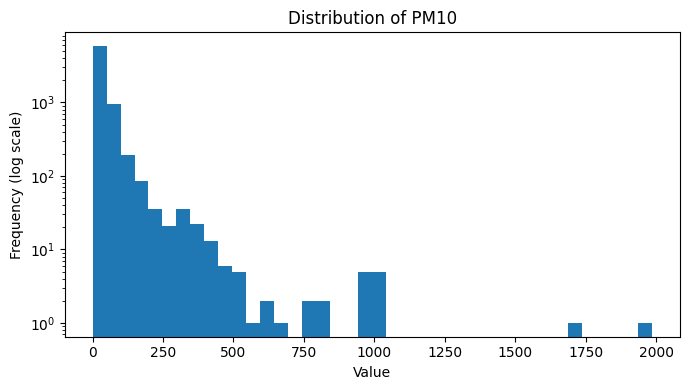

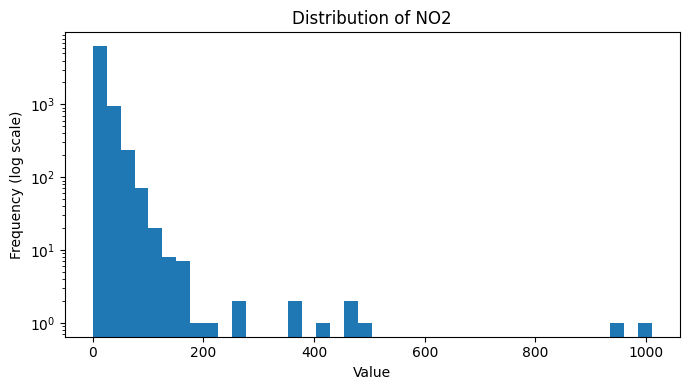

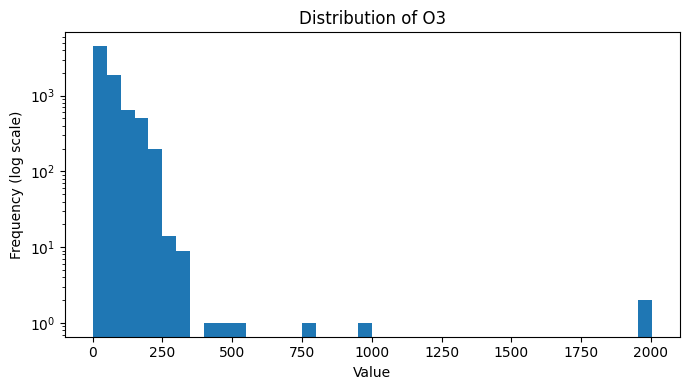

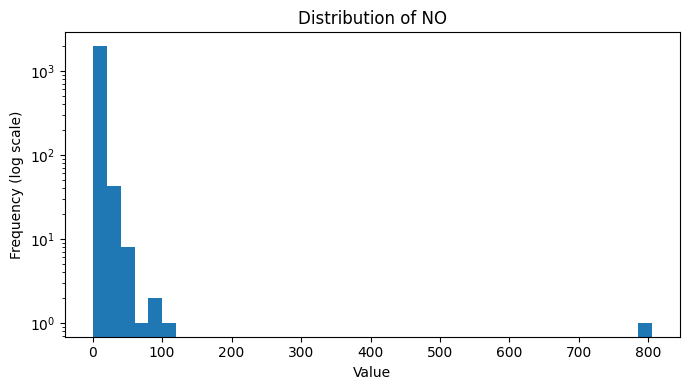

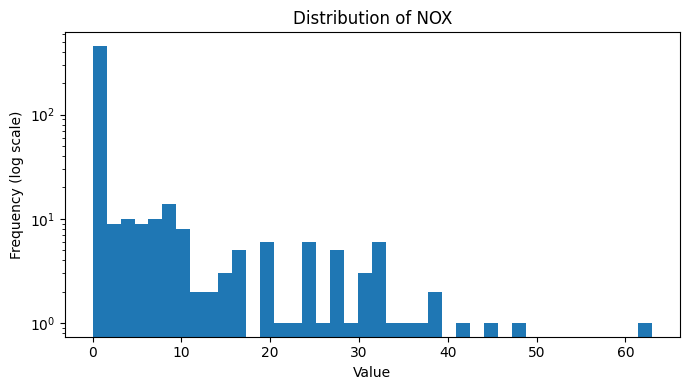

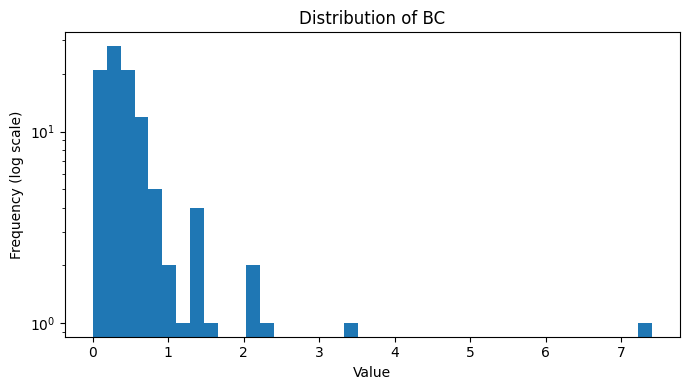

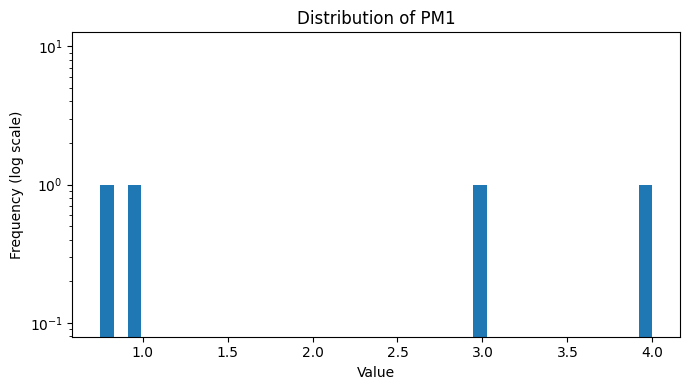

In [22]:
for p in pollutants_distinct:
    subset = df[df["Pollutant"] == p]["Value"]
    if len(subset) > 0:
        plt.figure(figsize=(7,4))
        plt.hist(subset, bins=40)
        plt.yscale("log")
        plt.title(f"Distribution of {p}")
        plt.xlabel("Value")
        plt.ylabel("Frequency (log scale)")
        plt.tight_layout()
        plt.show()


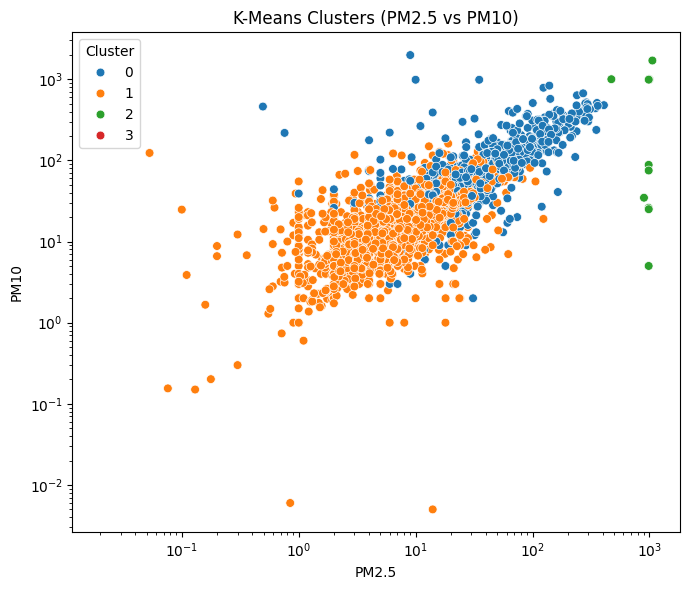

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Define pivot DataFrame (assuming df and pollutants_distinct are defined)
pivot = df.pivot_table(
    index=["Latitude", "Longitude"],
    columns="Pollutant",
    values="Value",
    aggfunc="mean"
).fillna(0) # Changed .dropna() to .fillna(0) to prevent empty DataFrame

pivot = pivot[[col for col in pivot.columns if col in pollutants_distinct]]

cluster_df = pivot.copy()

scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_df)

kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_df["Cluster"] = kmeans.fit_predict(scaled)

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=cluster_df,
    x="PM2.5", y="PM10",
    hue="Cluster",
    palette="tab10",
    s=40
)
plt.xscale("log"); plt.yscale("log")
plt.title("K-Means Clusters (PM2.5 vs PM10)")
plt.tight_layout()
plt.show()

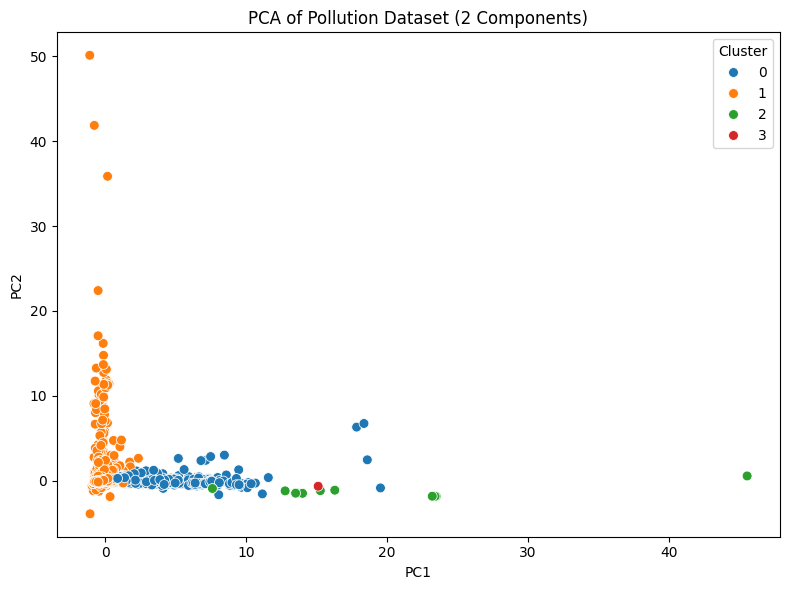

PCA Explained Variance: [0.18061222 0.1066424 ]


In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pc = pca.fit_transform(scaled)

cluster_df["PC1"] = pc[:,0]
cluster_df["PC2"] = pc[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=cluster_df, x="PC1", y="PC2",
    hue="Cluster", palette="tab10", s=50
)
plt.title("PCA of Pollution Dataset (2 Components)")
plt.tight_layout()
plt.show()

print("PCA Explained Variance:", pca.explained_variance_ratio_)

In [ ]:
import folium
from folium.plugins import MarkerCluster

df_sample = df.sample(n=1000, random_state=42) # Taking a sample for better map rendering

cluster_map = folium.Map(location=[20,0], zoom_start=2)
marker_cluster = MarkerCluster().add_to(cluster_map)

for _, row in df_sample.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        tooltip=f"{row['Pollutant']} = {row['Value']} ({row['Country Label']})"
    ).add_to(marker_cluster)

cluster_map.save("cluster_pollution_map.html")
print("Saved: cluster_pollution_map.html")

Saved: cluster_pollution_map.html
